Setup

In [1]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import keras
from keras import layers

In [2]:
# Load and prepare the MNIST dataset.
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# # Part A: PCA
1. Perform Exploratory Data Analysis (EDA) on X_train and discuss the data and what
you observe prior to beginning modeling (visualize the images) [10 pts]

In [3]:
print("Object type: ", type(X_train))
print("Values type: ", type(X_train[0][0][0]))
print("Dimensions: ", X_train.shape)
print("Values  range: ", X_train.min(), "-", X_train.max())
print("Missing values: ", sum(sum(sum(np.isnan(X_train)))))

Object type:  <class 'numpy.ndarray'>
Values type:  <class 'numpy.uint8'>
Dimensions:  (60000, 28, 28)
Values  range:  0 - 255
Missing values:  0


We have a numpy array of 60000 28x28 pixel images. Each pixel is a grayscale integer value ranging from 0 to 255. There are no NA values.

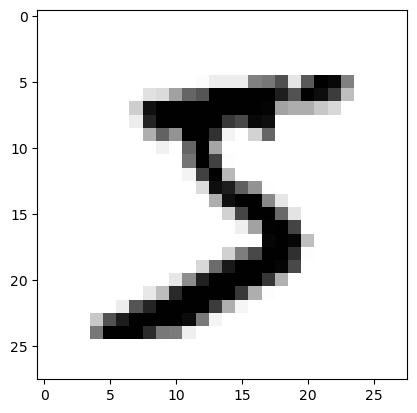

In [4]:
plt.imshow(X_train[0].reshape([28, 28]), 
           cmap=plt.cm.binary)

The first item in the set appears to be the hand-written number 5.

2. Normalize the image data so the pixel values are between 0 and 1. [10 pts]

In [5]:
X_train_normalized = X_train.astype('float32') / 255
X_test_normalized = X_test.astype('float32') / 255

3. Use PCA to reduce the 784 dimensions of the data to 32 dimensions using X_train [10
pts]

In [6]:
# I start by flattening the data to 2 dim
X_train_flat = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_test_flat = X_test_normalized.reshape(X_test_normalized.shape[0], -1)
pca = PCA(n_components=32)
# I fit my pca to the training data and transform both the training and testing data.
X_train_reduced = pca.fit_transform(X_train_flat)
X_test_reduced = pca.transform(X_test_flat)
# The new shape is 60000 rows by 32 features.
X_train_reduced.shape

(60000, 32)

4. Transform X_train, discuss the original variance in X_train and how much variance is
explained by the 32 components. Plot the variance explained as a function of the
number of components used and explain why the shape of the plot is what it is (use
what we know about PCA) [20 pts]

In [7]:
# X_train was transformed in the above.
print("Original variance: ", np.var(X_train_flat))
print("Reduced variance: ", np.var(X_train_reduced))
#There appears to be more overall variance in the reduced data.
pca.explained_variance_

Original variance:  0.09493039
Reduced variance:  1.2252


array([5.1168704 , 3.7413929 , 3.2527106 , 2.8416286 , 2.5671167 ,
       2.273666  , 1.7251536 , 1.5205615 , 1.4563065 , 1.2427502 ,
       1.1120895 , 1.0666404 , 0.9046815 , 0.89218104, 0.83235335,
       0.7819005 , 0.69838667, 0.673255  , 0.6259957 , 0.60776347,
       0.56214577, 0.53079855, 0.5027788 , 0.48114628, 0.4657828 ,
       0.44251123, 0.42842406, 0.41461805, 0.39251718, 0.3642502 ,
       0.34694558, 0.34171227], dtype=float32)

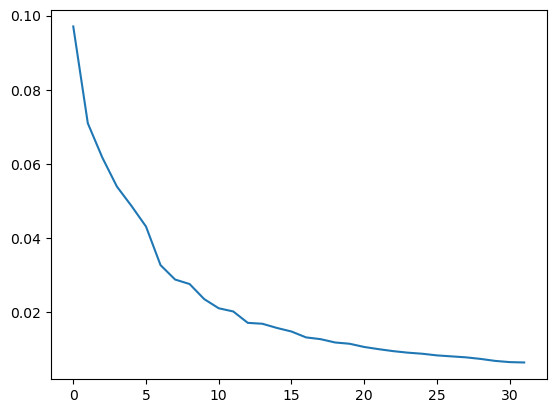

In [8]:
plt.plot(pca.explained_variance_ratio_)

I use explained_variance_ratio_ instead of explained_variance_ only because I find it easier to intuit. The shape of the plot would be the same either way, just with different y-axis values.
This plot shows:
* No one of the reduced features explains more than 10% of the variance.
* There is a sharp dropoff in our curve, implying the top 5 or 10 reduced features explain much more of the variance than the rest.
* As we add more and more features, each one explains less and less of the remaining variance.

Now, I'm not sure if you wanted us to actually plot the change in explained_variance_ across multiple PCAs of increasing length, so I also do that next.

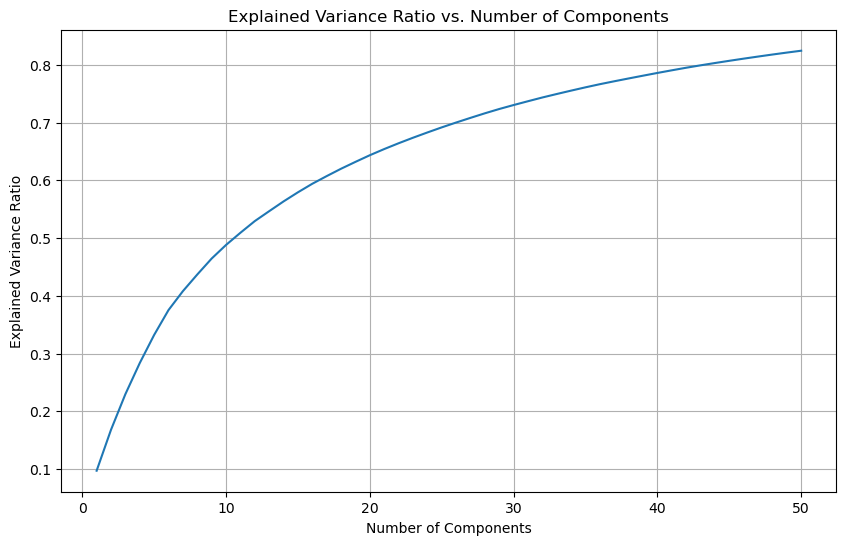

In [11]:
# Calculate explained variance for different number of components
explained_variance_ratio = []
n_components_range = range(1, 51)

for n in n_components_range:
    pca_temp = PCA(n_components=n)
    pca_temp.fit(X_train_flat)
    explained_variance_ratio.append(np.sum(pca_temp.explained_variance_ratio_))

# Plot explained variance as a function of number of components
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, explained_variance_ratio, marker='')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

This graph also suggests all the trends observed in our prior graph. It also demonstrates the way that PCA aims to capture as much as possible of the original variance, since as we increase the number of components in each PCA, the sums of explained_variance_ratio_s approach 1.

5. Using the transform fit on X_train, transform X_test and discuss the original variance
in X_test and how much variance is explained on X_test by the 32 components. [20
pts]

In [23]:
# X_test was transformed above
print("Original train variance: ", sum(np.var(X_train_flat, axis=0)))
print("Original test variance: ", sum(np.var(X_test_flat, axis=0)))
print("Reduced train variance: ", sum(np.var(X_train_reduced, axis=0)))
print("Reduced test variance: ", sum(np.var(X_test_reduced, axis=0)))
# The variance in the original & reduced testing data appears to be very close to the variance in the corresponding training data.
print("Explained variance ratio in training data: ", sum(pca.explained_variance_ratio_))

#I calculate explained variance manually as the ratio of total variance in our transformed vs original datasets. Before using this method to obtain explained variance for the test data, I demonstrate its accuracy by also using it on the training set and comparing this value to the value given by sum(pca.explained_variance_ratio_).

print("Explained variance ratio in training data: ", sum(np.var(X_train_reduced, axis=0)) / sum(np.var(X_train_flat, axis=0)))
print("Explained variance ratio in testing data: ", sum(np.var(X_test_reduced, axis=0)) / sum(np.var(X_test_flat, axis=0)))

Original train variance:  52.724641654886454
Original test variance:  52.84803419234049
Reduced train variance:  39.20610225200653
Reduced test variance:  39.65792864561081
Explained variance ratio in training data:  0.7436008024960756
Explained variance ratio in training data:  0.7436011136620586
Explained variance ratio in testing data:  0.7504144525277084


The variance in both the original test data and the transformed test data appear to be very similar to the variance in the corresponding original & transformed *training* data sets. Manually dividing the summed variances gives a *very* similar value to that given by pca.explained_variance_ratio_, so it should also be accurate for calculating explained variance in the *test* data.

Our PCA seems to explain about the same (just slightly *more*) variance in our testing data as in our training data. About 75%. This suggests that our PCA is effective at capturing variance in our test set as much as in our training set, and that it should be acceptable for further use.

6. Compare results from #4 and #5 [10 pts]
Hint: See Workbook 11 from class.

As discussed above, the results for questions 4 (explained variance in our training data) and 5 (explained variance in our testing data) appear to be very close. In other words, the variance explained by the 32 components of X_train_reduced on X_train and the variances explained by the 32 components of X_test_reduced on X_test are very similar. 

This speaks to the strength of our PCA model and PCA in general. Our PCA appears to be successfully capturing meaningful information (in the form of variance) from our features and retaining as much of that information as possible while reducing the number of features dramatically, and it is doing so in a way that generalizes to the testing data.

# Part B: AutoEncoder
1. Start with data after step #2 from Section A

In [14]:
# From step 2A we had our normalized X data. 
# X_test_normalized
# X_train_normalized

2. Build an autoencoder (either at least 1 hidden layer or using CNN) that will reduce the 784 dimensions of the data to 32 dimensions [20 pts]

In [104]:
# All autoencoder code adapted from: https://blog.keras.io/building-autoencoders-in-keras.html

# Input image
input_img = keras.Input(shape=(28,28,1))

### ENCODING ###
# My first plan was to produce a model with a Conv2D and a MaxPooling layer since this is image data:
# encoded = layers.Conv2D(32, kernel_size=3, 
#                        activation='relu')(input_img)
# encoded = layers.MaxPooling2D(pool_size=(2, 2))(encoded)
# encoded = layers.Flatten()(encoded)

# HOWEVER, this will change the dimensions to (28x28x32) after convolution and (14,14,32) after pooling. I don't think either of these match up to the dimensions you request, flattening would produce a single massive dimension from these, and I'm not sure if Reshape will produce a correct encoding and do so effectively. So, I settled for using hidden layers.

# Flatten, to reproduce our flat data
encoded = layers.Flatten()(input_img)
# I opt for 2 dense layers that eventually reduce the data down to a dim of 32
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

### DECODING ###
# I start by expanding (32,1) back out to (784,1)
decoded = layers.Dense(784, activation='sigmoid')(encoded)
# I then reshape to reproduce the shape of the input data
decoded = layers.Reshape((28, 28))(decoded)

# Autoencoder model that maps an input to its encoding
autoencoder = keras.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

By encoding and then decoding the data, this model simply produces a reconstruction that can be used for assessing the power of the encoding/decoding method.

3. Train an autoencoder on X_train. Discuss the original variance in X_train and how
much variance is explained by the 32 dimensions. Hint: Use “model.predict(X_train)”
to get predictions [20 pts]

In [108]:
# Fitting my autoencoder
autoencoder.fit(X_train_normalized, X_train_normalized,
                epochs=50,
                # This batch size will result in sampling about (256/784=) ~ 1/3 of the data per batch.
                batch_size=32,
                shuffle=True,
                validation_data=(X_test_normalized, X_test_normalized))
# Producing predictions (reconstructions) from the autoencoder
X_train_reconstructed = autoencoder.predict(X_train_normalized)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0922 - val_loss: 0.0901
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0912 - val_loss: 0.0898
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0911 - val_loss: 0.0899
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0908 - val_loss: 0.0899
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0905 - val_loss: 0.0897
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0905 - val_loss: 0.0895
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0906 - val_loss: 0.0894
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0907 - val_loss: 0.0898
Epoch 9/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0905 - val_loss: 0.0895
Epoch 10/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0904 - val_loss: 0.0893
Epoch 11/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0904 - val_loss: 0.0894
Epoch 12/50
1875/1875 ━━━━━━━━

In [109]:
print("Autoencoder decoded train data variance: ", sum(sum(np.var(X_train_reconstructed, axis=0))))
print("Original train data variance: ", sum(sum(np.var(X_train_normalized, axis=0))))
print("Explained variance ratio: ", sum(sum(np.var(X_train_reconstructed, axis=0))) / sum(sum(np.var(X_train_normalized, axis=0))))

# The below calculates the difference in variance retained by the autoencoder vs our earlier PCA.
performance_improvement = sum(sum((np.var(X_train_reconstructed, axis=0)))) / (sum(sum(np.var(X_train_normalized, axis=0)))) - sum(np.var(X_train_reduced, axis=0)) / sum(sum(np.var(X_train_normalized, axis=0)))
print(f"Improvement over PCA method: {round(100*performance_improvement,2)}%")

Autoencoder decoded train data variance:  45.65403655076807
Original train data variance:  52.72464179439703
Explained variance ratio:  0.8658956229384882
Improvement over PCA method: 12.23%


This method manages to capture ~87% of the variance, an 12.23% improvement in explained variance over our PCA model.

4. Using the model trained on X_train, transform X_test and discuss the original variance
in X_test and how much variance is explained on X_test by the 32 dimensions of the
autoencoder. Hint: Use “model.predict(X_test)” to get predictions. [20 pts]

In [110]:
X_test_reconstructed = autoencoder.predict(X_test_normalized)

print("Autoencoder decoded test data variance: ", sum(sum(np.var(X_test_reconstructed, axis=0))))
print("Original test data variance: ", sum(sum(np.var(X_test_normalized, axis=0))))
print("Explained variance ratio: ", sum(sum(np.var(X_test_reconstructed, axis=0))) / sum(sum(np.var(X_test_normalized, axis=0))))

# The below calculates the difference in variance retained by the autoencoder vs our earlier PCA.
performance_improvement = sum(sum(np.var(X_test_reconstructed, axis=0))) / (sum(sum(np.var(X_test_normalized, axis=0)))) - sum(np.var(X_test_reduced, axis=0)) / sum(sum(np.var(X_test_normalized, axis=0)))
print(f"Improvement over PCA method: {round(100*performance_improvement,2)}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
Autoencoder decoded test data variance:  46.07250482683594
Original test data variance:  52.84803447469312
Explained variance ratio:  0.871792211097241
Improvement over PCA method: 12.14%


As previously observed, X_test (uncompressed) has slightly more variance than X_train. This could be expected given basic statistics, since the test set is smaller than the train set and smaller samples have higher likelihood of sampling variability. That said, the difference is not very large. This is also true of the autoencoder decoded test data variance, if you compare it to the results for the training data from the previous step. The explained variance ratio of our decoded set to our original set is slightly higher for this test data than it was for our training data. This is an 12.14% improvement in explained variance over our PCA method for the testing data, about the same our 12.23% improvement over PCA on the training data.

5. Compare results from #3 and #4 and why it is important to test out of sample [10 pts]

Hint: You can just modify code from here
https://blog.keras.io/building-autoencoders-in-keras.html

The explained variance ratios for both our decoded testing set and our decoded training set are very similar. This is good, as it implies that the encoding/decoding method generalizes well to unseen data; it performs well and is not overfit. A model that performs as well on testing data as it does on training data is likely to perform well on real-world data. It is important to test out of sample in order to assess all of the above, as we have here.

At this point it could be beneficial to test performance on *further* data, like a validation set. 

# Part C: Explain Results
Discuss which approach explained more variance of the mnist data and why this might be the
case (not just based on number of parameters). Also, discuss how many parameters each
model/transform uses and which uses more parameters. Lastly, discuss when you may want to
use these approaches.

The autoencoder method explained roughly 12% more variance than the PCA method. I re-ran fit and predict multiple times on both models and their explained variance ratios didn't seem to change by more than about 1%. On multiple re-runs of fit & predict, the autoencoder model consistently yielded results ranging from between about an 11.8% to 12.3% improvement over PCA. This may be due to the fact that PCA is linear, whereas Neural Networks are not. This means our autoencoder model could capture non-linear trends in the data (particularly with the Relu activation layers) that PCA cannot, contributing to the improved performance.

The number of parameters in a PCA is: input dim x number of components + number of components = 784 * 32 + 32 = 25120.
Total PCA parameters = 25120

The number of parameters in our neural net autoencoder is:
Dense layer 1 (encoding): (784 * 64) + 64 (weights) + 64 (biases) = 50304
Dense layer 2 (encoding): (64 * 32) + 32 (weights) + 32 (biases) = 2112
Dense layer 3 (decoding): (32 * 784) + 784 (weights) + 784 (biases) = 26656
All other layers have no parameters.
Total autoencoder parameters = 79072

Our autoencoder has more than 3 times more parameters (and 2 times more even just in the encoding step). This also contributes to greater training time for the autoencoder.

PCA is faster and less computationally intensive than training an autoencoder. PCA is faster, may be better at detecting linear relationships (in other words, probably better for data that is *not* image data), and is more interpretable than a neural network (which is a black box). It can be useful to start with PCA for quick and easy EDA or tasks that require speed over accuracy. It could also be useful as a baseline, to then compare with the performance of more complex models like autoencoders to assess whether the additional complexity and computational intensity is justified.

Autoencoders are more powerful than PCA. They are better at detecting non-linear trends in the data (so probably better for image data). They can learn hierarchical representations in the data (meaning they are more powerful for capturing more information in the same size encoding), which makes them more powerful for tasks like generating new data or feature learning, which would make it a more useful method of processing prior to downstream tasks like classification or clustering.